# Model Halves

In [7]:
from glob import glob
from scipy import stats
from math import sqrt
import nibabel as nb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_palette('muted')

#removed WMAZE_007 due to no 2nd level late_nonlearn
sids = ['WMAZE_001', 'WMAZE_002', 'WMAZE_004', 'WMAZE_005', 'WMAZE_006',
        'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012', 
        'WMAZE_017', 'WMAZE_018', 'WMAZE_019', 'WMAZE_020', 'WMAZE_021',
        'WMAZE_022', 'WMAZE_023', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']

proj_dir = '/home/data/madlab/data/mri/wmaze' 
mask_filenames = []
cope_files = []
for SID in sids:
    mask_filenames_glob = glob(proj_dir + '/roi_analysis/MRthesis/fb4c_2/mask/anat_masks/_subject_id_' 
                               + SID + '/_anatmask_xfm*/*')
    mask_filenames.append(mask_filenames_glob)
    subjcopes_glob = glob(proj_dir + '/scndlvl/wmaze_MRthesis/fixed_before_conditional/old/model_HALVES/' 
                          + SID + '/fixedfx/cope_*')
    subjcopes_glob.sort()
    cope_files.append(subjcopes_glob)
    
    if len(cope_files[-1]) == 0 or len(cope_files[-1]) != 16: 
        print(SID)

WMAZE_007


## Cell to double-check the array indexing

In [3]:
#change first index of cope_files to indicate participant index in sids array
for i, curr_mask in enumerate(mask_filenames[0]):
    print(i, mask_filenames[0][i].split('/')[-1][:-7])  

(0, 'lh-hippocampus_warped')
(1, 'lh_caudate_anat_mask_warped')
(2, 'rh_caudate_anat_mask_warped')
(3, 'lh-dmPFC_warped')
(4, 'lh-mPFC_lausanne_warped')
(5, 'lh-mPFC_fs_warped')
(6, 'lh-motor_warped')
(7, 'lh-mPFC_fs-3reg_warped')
(8, 'rh-hippocampus_warped')
(9, 'rh-dmPFC_warped')
(10, 'rh-mPFC_lausanne_warped')
(11, 'rh-mPFC_fs_warped')
(12, 'rh-motor_warped')
(13, 'rh-mPFC_fs-3reg_warped')
(14, 'lh-putamen_warped')
(15, 'rh-putamen_warped')


In [6]:
for i, curr_cope in enumerate(cope_files[0]):
    print(i, cope_files[0][i].split('/')[-1][5:-7]) 
    
print cope_files[0][1]

(0, 'AllVsBase')
(1, 'all_early_minus_all_late')
(2, 'all_late_minus_all_early')
(3, 'all_remaining')
(4, 'early_learn_minus_early_nonlearn')
(5, 'early_learn_minus_late_learn')
(6, 'early_learning')
(7, 'early_nonlearn_minus_early_learn')
(8, 'early_nonlearn_minus_late_nonlearn')
(9, 'early_nonlearning')
(10, 'late_learn_minus_early_learn')
(11, 'late_learn_minus_late_nonlearn')
(12, 'late_learning')
(13, 'late_nonlearn_minus_early_nonlearn')
(14, 'late_nonlearn_minus_late_learn')
(15, 'late_nonlearning')
/home/data/madlab/data/mri/wmaze/scndlvl/wmaze_MRthesis/fixed_before_conditional/old/model_HALVES/WMAZE_001/fixedfx/cope_all_early_minus_all_late.nii.gz


### Use binarized mask to obtain activation in left & right hemisphere for each region of interest

In [2]:
all_data = {'subjid':[],
            #HPC
            'lhhp_early_learn':[], 'rhhp_early_learn':[], 'lhhp_late_learn':[], 'rhhp_late_learn':[],
            'lhhp_early_nonlearn':[], 'rhhp_early_nonlearn':[], 'lhhp_late_nonlearn':[], 'rhhp_late_nonlearn':[],
            #mPFC
            'lhmpfc_early_learn':[], 'rhmpfc_early_learn':[], 'lhmpfc_late_learn':[], 'rhmpfc_late_learn':[],
            'lhmpfc_early_nonlearn':[], 'rhmpfc_early_nonlearn':[], 'lhmpfc_late_nonlearn':[], 'rhmpfc_late_nonlearn':[],
            #Caudate
            'lhcaud_early_learn':[], 'rhcaud_early_learn':[], 'lhcaud_late_learn':[], 'rhcaud_late_learn':[],
            'lhcaud_early_nonlearn':[], 'rhcaud_early_nonlearn':[], 'lhcaud_late_nonlearn':[], 'rhcaud_late_nonlearn':[],
            #Putamen
            'lhput_early_learn':[], 'rhput_early_learn':[], 'lhput_late_learn':[], 'rhput_late_learn':[],
            'lhput_early_nonlearn':[], 'rhput_early_nonlearn':[], 'lhput_late_nonlearn':[], 'rhput_late_nonlearn':[]}

for i in range(len(sids)):
    all_data['subjid'].append(sids[i])
    lh_hp_img = nb.load(mask_filenames[i][0])
    rh_hp_img = nb.load(mask_filenames[i][8])
    lh_mpfc_img = nb.load(mask_filenames[i][5])
    rh_mpfc_img = nb.load(mask_filenames[i][11])
    lh_caud_img = nb.load(mask_filenames[i][1])
    rh_caud_img = nb.load(mask_filenames[i][2])
    lh_put_img = nb.load(mask_filenames[i][14])
    rh_put_img = nb.load(mask_filenames[i][15])
    
    early_learn_img = nb.load(cope_files[i][6])
    late_learn_img = nb.load(cope_files[i][12])
    early_nonlearn_img = nb.load(cope_files[i][9])
    late_nonlearn_img = nb.load(cope_files[i][15])
    
    region = ['hp', 'mpfc', 'caud', 'put']
    learn_type = ['early_learn', 'late_learn', 'early_nonlearn', 'late_nonlearn']
   
    for r in region:
        for l in learn_type:
            lh_data = eval('{0}_img.get_data()[lh_{1}_img.get_data() > 0.]'.format(l,r))
            all_data['lh{0}_{1}'.format(r,l)].append(np.mean(lh_data))            
            rh_data = eval('{0}_img.get_data()[rh_{1}_img.get_data() > 0.]'.format(l,r))
            all_data['rh{0}_{1}'.format(r,l)].append(np.mean(rh_data))

all_data_df = pd.DataFrame(all_data)

### Combine the two hemispheres to create one regional average

In [33]:
region = ['hp', 'mpfc', 'caud', 'put']
learn_type = ['early_learn', 'late_learn', 'early_nonlearn', 'late_nonlearn']
for r in region:
    for l in learn_type:
        all_data_df['{0}_all_{1}'.format(r,l)] = (all_data_df['lh{0}_{1}'.format(r,l)] 
                                                  + all_data_df['rh{0}_{1}'.format(r,l)])/2.

## Hippocampus

In [4]:
hp_chart = {}
for x in ['early_learn', 'late_learn', 'early_nonlearn', 'late_nonlearn']:
    hp_chart['{0}'.format(x)] = all_data_df['hp_all_{0}'.format(x)] 
hp_chart_df = pd.DataFrame.from_dict(hp_chart)

In [5]:
hp_chart_df

,early_learn,early_nonlearn,late_learn,late_nonlearn
0,0.419794,0.683453,0.417978,2.907409
1,-5.009438,-7.903021,-6.524716,-6.713285
2,1.126333,0.527425,2.401505,2.727571
3,-0.376072,-3.701677,0.303185,0.272023
4,-1.445610,-0.872663,-0.624472,-0.373629
5,-0.808468,-0.121015,-0.349234,-0.490069
6,-1.007543,-1.491377,-2.189295,-1.518280
7,-0.808314,-4.048887,-3.751085,-4.720895
8,-1.033626,-4.034956,-0.196974,-2.470157
9,1.246265,-0.119973,-0.019766,0.898961


Mean early_learn:  -0.818800031551
STD early_learn:  1.93886722506

Mean late_learn:  -1.06809083068
STD late_learn:  2.44835351867

Mean early_nonlearn:  -1.43196631635
STD early_nonlearn:  2.64093311799

Mean late_nonlearn:  -0.878936529748
STD late_nonlearn:  2.71709613806

Early vs. Late Learn t-test:  (0.66702878513355535, 0.51321449736148028)
Early vs. Late Nonlearn t-test:  (-1.4670636923236375, 0.15961375982568146)


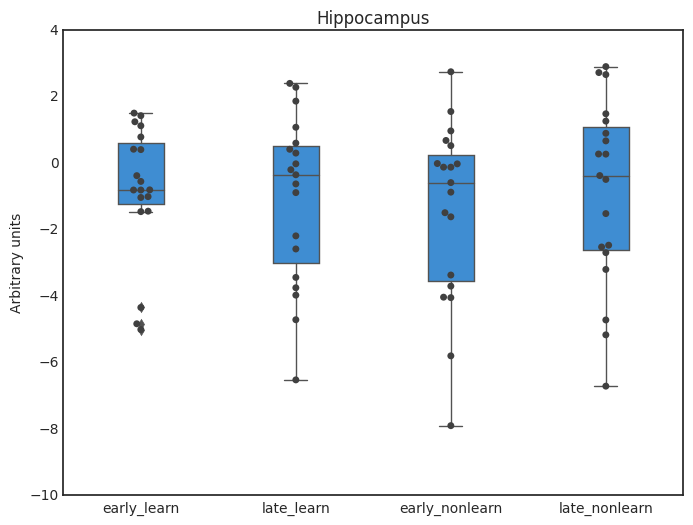

In [8]:
sns.set_style("white")
for d in ['early_learn', 'late_learn', 'early_nonlearn', 'late_nonlearn']:
    print "Mean {0}: ".format(d), np.mean(hp_chart['{0}'.format(d)])
    print "STD {0}: ".format(d), np.std(hp_chart['{0}'.format(d)])
    print ""
print "Early vs. Late Learn t-test: ", stats.ttest_rel(hp_chart['early_learn'], hp_chart['late_learn'])[:]
print "Early vs. Late Nonlearn t-test: ", stats.ttest_rel(hp_chart['early_nonlearn'], hp_chart['late_nonlearn'])[:]
N = 4
conditions = ['early_learn', 'late_learn', 'early_nonlearn', 'late_nonlearn']
hp_allsubjs = [hp_chart['early_learn'], hp_chart['late_learn'], 
               hp_chart['early_nonlearn'], hp_chart['late_nonlearn']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (8,6))
ax0 = sns.boxplot(data = hp_allsubjs, color = "#278fea", width = 0.3)
ax2 = sns.swarmplot(data = hp_allsubjs, color='.25')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("Arbitrary units")
ax.set_title("Hippocampus")
#plt.savefig("/home/arenf001/halves-HPC1.jpg", dpi = 1080)
plt.show()

Mean early:  -1.12538317395
STD early:  2.18252133666

Mean late:  -0.973513680216
STD late:  2.49870439932

Early vs. Late t-test:  (-0.46867987328377758, 0.64492456119206731)


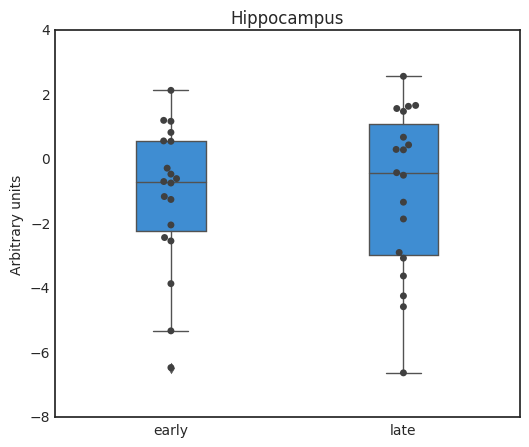

In [32]:
plot = {}
plot['early'] = all_data_df[['hp_all_early_learn','hp_all_early_nonlearn']].mean(axis=1)
plot['late'] = all_data_df[['hp_all_late_learn','hp_all_late_nonlearn']].mean(axis=1)
plot_df = pd.DataFrame.from_dict(plot)

for d in ['early', 'late']:
    print "Mean {0}: ".format(d), np.mean(plot['{0}'.format(d)])
    print "STD {0}: ".format(d), np.std(plot['{0}'.format(d)])
    print ""    
print "Early vs. Late t-test: ", stats.ttest_rel(plot['early'], plot['late'])[:]
                       
N = 2
conditions = ['early', 'late']
hp_allsubjs = [plot['early'], plot['late']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (6,5))
ax0 = sns.boxplot(data = hp_allsubjs, color = "#278fea", width = 0.3)
ax2 = sns.swarmplot(data = hp_allsubjs, color='.25')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("Arbitrary units")
ax.set_title("Hippocampus")
#plt.savefig("/home/arenf001/halves-HPC2.jpg", dpi = 1080)
plt.show()

## mPFC

In [15]:
mpfc_chart = {}
for x in ['early_learn', 'late_learn', 'early_nonlearn', 'late_nonlearn']:
    mpfc_chart['{0}'.format(x)] = all_data_df['mpfc_all_{0}'.format(x)] 
mpfc_chart_df = pd.DataFrame.from_dict(mpfc_chart)

In [16]:
mpfc_chart_df

,early_learn,early_nonlearn,late_learn,late_nonlearn
0,0.918298,-1.589642,1.314111,3.156925
1,-3.431127,-7.395319,-3.700661,-6.674686
2,0.154035,-0.861398,1.680491,2.228913
3,0.314386,-2.174422,2.108455,4.792186
4,-2.251388,-2.955458,-0.603991,-2.188478
5,1.183516,-0.458477,2.245473,1.432277
6,-4.246774,-5.580336,-5.269410,-5.721530
7,-4.565593,-6.465851,-6.152014,-7.198882
8,-0.355726,-0.340944,-0.157616,-1.063374
9,2.655207,3.573424,3.036675,3.419889


Mean early_learn:  -0.832433827712
STD early_learn:  2.63127529441

Mean late_learn:  -0.648459702534
STD late_learn:  3.29187817766

Mean early_nonlearn:  -1.23656921363
STD early_nonlearn:  3.61035790927

Mean late_nonlearn:  -0.228868442539
STD late_nonlearn:  3.69339044424

Early vs. Late Learn t-test:  (-0.59594211038522493, 0.55863400842586086)
Early vs. Late Nonlearn t-test:  (-1.6126707085415952, 0.124210568697549)


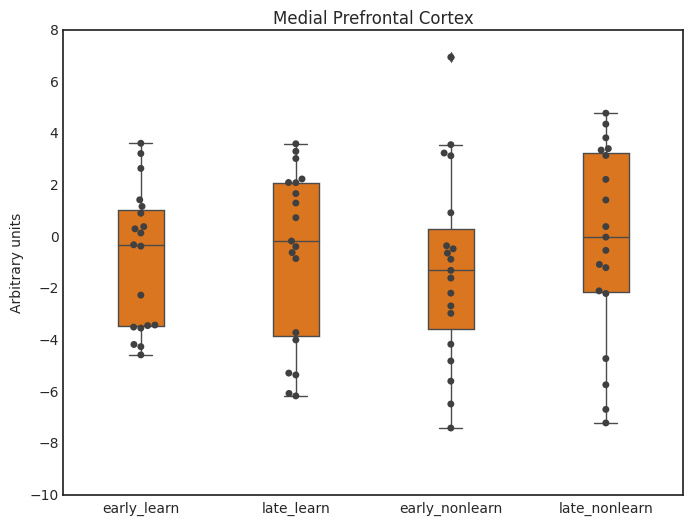

In [17]:
for d in ['early_learn', 'late_learn', 'early_nonlearn', 'late_nonlearn']:
    print "Mean {0}: ".format(d), np.mean(mpfc_chart['{0}'.format(d)])
    print "STD {0}: ".format(d), np.std(mpfc_chart['{0}'.format(d)])
    print ""
print "Early vs. Late Learn t-test: ", stats.ttest_rel(mpfc_chart['early_learn'], mpfc_chart['late_learn'])[:]
print "Early vs. Late Nonlearn t-test: ",stats.ttest_rel(mpfc_chart['early_nonlearn'], mpfc_chart['late_nonlearn'])[:]
 
N = 4
conditions = ['early_learn', 'late_learn', 'early_nonlearn', 'late_nonlearn']
mpfc_allsubjs = [mpfc_chart['early_learn'], mpfc_chart['late_learn'],
                 mpfc_chart['early_nonlearn'], mpfc_chart['late_nonlearn']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (8,6))
ax0 = sns.boxplot(data = mpfc_allsubjs, color = "#f97401", width = 0.3)
ax2 = sns.swarmplot(data = mpfc_allsubjs, color='.25')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("Arbitrary units")
ax.set_title("Medial Prefrontal Cortex")
#plt.savefig("/home/arenf001/halves-mpfc.jpg", dpi = 1080)
plt.show()

Mean early:  -1.03450152067
STD early:  3.01109188387

Mean late:  -0.438664072536
STD late:  3.37928002327

Early vs. Late t-test:  (-1.387920760979992, 0.18210287770341335)


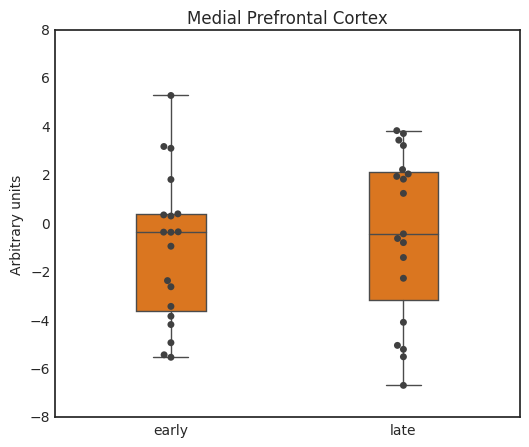

In [31]:
plot2 = {}
plot2['early'] = all_data_df[['mpfc_all_early_learn','mpfc_all_early_nonlearn']].mean(axis=1)
plot2['late'] = all_data_df[['mpfc_all_late_learn','mpfc_all_late_nonlearn']].mean(axis=1)
plot2_df = pd.DataFrame.from_dict(plot2)

for d in ['early', 'late']:
    print "Mean {0}: ".format(d), np.mean(plot2['{0}'.format(d)])
    print "STD {0}: ".format(d), np.std(plot2['{0}'.format(d)])
    print ""    
print "Early vs. Late t-test: ", stats.ttest_rel(plot2['early'], plot2['late'])[:]
                       
N = 2
conditions = ['early', 'late']
mpfc_allsubjs = [plot2['early'], plot2['late']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (6,5))
ax0 = sns.boxplot(data = mpfc_allsubjs, color = "#f97401", width = 0.3)
ax2 = sns.swarmplot(data = mpfc_allsubjs, color='.25')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("Arbitrary units")
ax.set_title("Medial Prefrontal Cortex")
#plt.savefig("/home/arenf001/halves-mpfc2.jpg", dpi = 1080)
plt.show()

## Caudate

In [20]:
caud_chart = {}
for x in ['early_learn', 'late_learn', 'early_nonlearn', 'late_nonlearn']:
    caud_chart['{0}'.format(x)] = all_data_df['caud_all_{0}'.format(x)] 
caud_chart_df = pd.DataFrame.from_dict(caud_chart)

In [21]:
caud_chart_df

,early_learn,early_nonlearn,late_learn,late_nonlearn
0,7.115047,3.992658,1.132422,5.088925
1,-1.795894,-5.707460,-3.038950,-4.432319
2,1.879712,-0.176573,1.068074,0.506824
3,4.995865,1.850719,5.394430,4.405126
4,-2.717110,-2.686082,-4.192222,-4.123295
5,1.881152,1.543798,0.904600,-0.080188
6,1.548981,0.752545,-2.152304,-0.704797
7,2.785360,3.983549,0.499699,-0.989945
8,2.353981,-3.137753,0.015916,-1.270962
9,5.746642,4.231850,3.958516,5.876891


Mean early_learn:  2.63327586577
STD early_learn :  2.43871100325

Mean late_learn:  0.549478714207
STD late_learn :  2.60882353021

Mean early_nonlearn:  1.38225065819
STD early_nonlearn :  3.57025959261

Mean late_nonlearn:  1.09017610334
STD late_nonlearn :  3.17737538793

Early vs. Late Learn t-test:  (4.8329728402629009, 0.00013344652070724274) **
Early vs. Late Nonlearn t-test:  (0.47238611097205296, 0.64232795363673878)


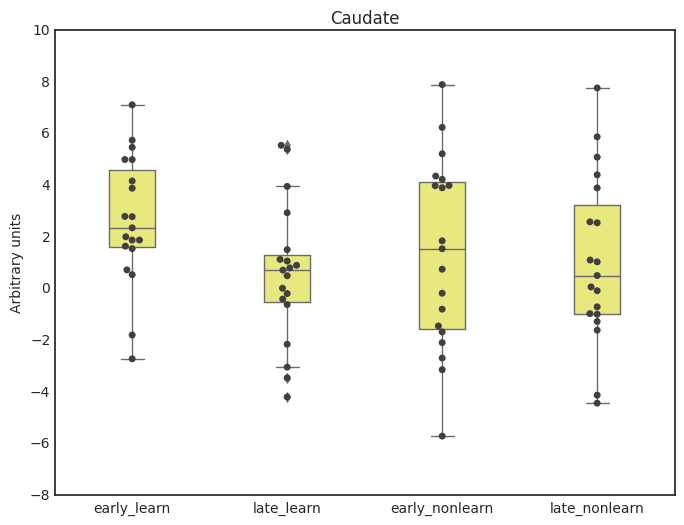

In [23]:
for d in ['early_learn', 'late_learn', 'early_nonlearn', 'late_nonlearn']:
    print "Mean {0}: ".format(d), np.mean(caud_chart['{0}'.format(d)])
    print "STD {0} : ".format(d), np.std(caud_chart['{0}'.format(d)])
    print ""
print "Early vs. Late Learn t-test: ", stats.ttest_rel(caud_chart['early_learn'], caud_chart['late_learn'])[:], "**"
print "Early vs. Late Nonlearn t-test: ",stats.ttest_rel(caud_chart['early_nonlearn'], caud_chart['late_nonlearn'])[:]
N = 4
conditions = ['early_learn', 'late_learn', 'early_nonlearn', 'late_nonlearn']
caud_allsubjs = [caud_chart['early_learn'], caud_chart['late_learn'],
                 caud_chart['early_nonlearn'], caud_chart['late_nonlearn']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (8,6))
ax0 = sns.boxplot(data = caud_allsubjs, color = "#f9f96d", width = 0.3)
ax2 = sns.swarmplot(data = caud_allsubjs, color='.25')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("Arbitrary units")
ax.set_title("Caudate")
#plt.savefig("/home/arenf001/halves-caud.jpg", dpi = 1080)
plt.show()

Mean early :  2.00776326198
STD early:  2.86174825052

Mean late :  0.819827408775
STD late:  2.7585413403

Early vs. Late t-test:  (2.7396526381823811, 0.013466239080495499) *


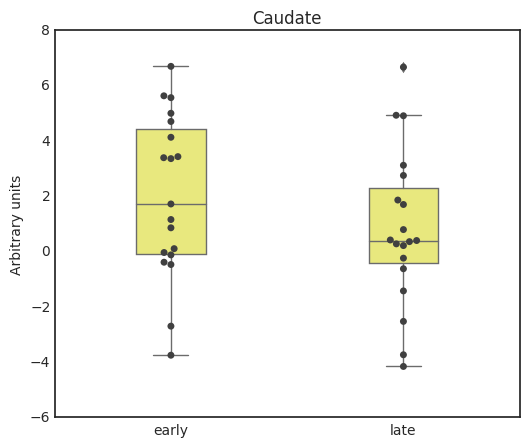

In [30]:
plot3 = {}
plot3['early'] = all_data_df[['caud_all_early_learn','caud_all_early_nonlearn']].mean(axis=1)
plot3['late'] = all_data_df[['caud_all_late_learn','caud_all_late_nonlearn']].mean(axis=1)
plot3_df = pd.DataFrame.from_dict(plot3)

sns.set_style("white")
for d in ['early', 'late']:
    print "Mean {0} : ".format(d), np.mean(plot3['{0}'.format(d)])
    print "STD {0}: ".format(d), np.std(plot3['{0}'.format(d)])
    print ""    
print "Early vs. Late t-test: ", stats.ttest_rel(plot3['early'], plot3['late'])[:], "*"
                       
N = 2
conditions = ['early', 'late']
caud_allsubjs = [plot3['early'], plot3['late']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (6,5))
ax0 = sns.boxplot(data = caud_allsubjs, color = "#f9f96d", width = 0.3)
ax2 = sns.swarmplot(data = caud_allsubjs, color='.25')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("Arbitrary units")
ax.set_title("Caudate")
#plt.savefig("/home/arenf001/halves-caud2.jpg", dpi = 1080)
plt.show()

## Putamen

In [26]:
put_chart = {}
for x in ['early_learn', 'late_learn', 'early_nonlearn', 'late_nonlearn']:
    put_chart['{0}'.format(x)] = all_data_df['put_all_{0}'.format(x)] 
put_chart_df = pd.DataFrame.from_dict(put_chart)

In [27]:
put_chart_df

,early_learn,early_nonlearn,late_learn,late_nonlearn
0,4.126452,5.809579,0.294266,4.571041
1,-3.585522,-5.755162,-3.506670,-3.372800
2,0.807962,-0.579922,0.252270,0.461027
3,-1.019342,-1.923424,-1.099221,-1.063372
4,-0.738825,-0.100612,-1.359436,-1.201502
5,0.102766,-0.828469,1.073618,-0.020148
6,-3.583837,-1.907971,-3.864843,-2.323383
7,0.784315,0.166065,-0.837664,-2.104578
8,1.434823,-1.724417,1.047790,-0.183129
9,1.521705,1.841101,2.390874,2.279006


Mean early_learn:  0.56348729761
STD early_learn:  2.06366698282

Mean late_learn:  -0.0638237466153
STD late_learn:  1.77327126464

Mean early_nonlearn:  0.335526398922
STD early_nonlearn:  2.79087719402

Mean late_nonlearn:  0.392574210137
STD late_nonlearn:  2.10188681308

Early vs. Late Learn t-test:  (2.0243917817050567, 0.058028354330264133)
Early vs. Late Nonlearn t-test:  (-0.13037734739649287, 0.89771390085613256)


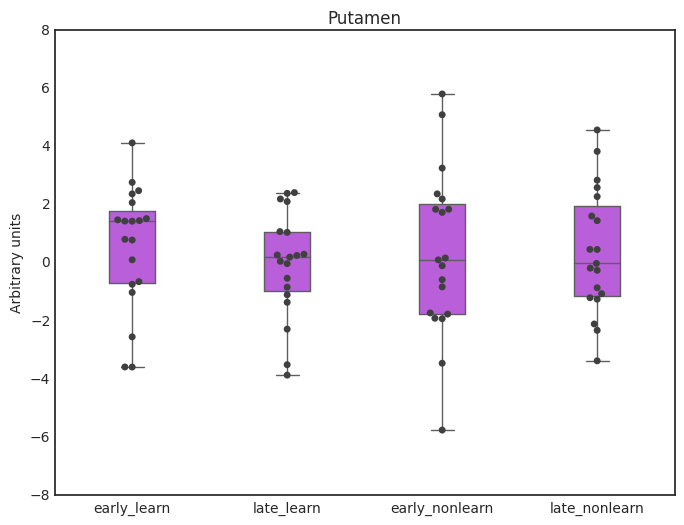

In [28]:
for d in ['early_learn', 'late_learn', 'early_nonlearn', 'late_nonlearn']:
    print "Mean {0}: ".format(d), np.mean(put_chart['{0}'.format(d)])
    print "STD {0}: ".format(d), np.std(put_chart['{0}'.format(d)])
    print ""
print "Early vs. Late Learn t-test: ", stats.ttest_rel(put_chart['early_learn'], put_chart['late_learn'])[:]
print "Early vs. Late Nonlearn t-test: ",stats.ttest_rel(put_chart['early_nonlearn'], put_chart['late_nonlearn'])[:]

N = 4
conditions = ['early_learn', 'late_learn', 'early_nonlearn', 'late_nonlearn']
put_allsubjs = [put_chart['early_learn'], put_chart['late_learn'],
                put_chart['early_nonlearn'], put_chart['late_nonlearn']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (8,6))
ax0 = sns.boxplot(data = put_allsubjs, color = "#c34aef", width = 0.3)
ax2 = sns.swarmplot(data = put_allsubjs, color='.25')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("Arbitrary units")
ax.set_title("Putamen")
#plt.savefig("/home/arenf001/halves-put.jpg", dpi = 1080)
plt.show()

Mean early:  0.449506848266
STD early:  2.32982932906

Mean late:  0.164375231761
STD late:  1.82305538787

Early vs. Late t-test:  (0.88319822631611933, 0.38877297719330028)


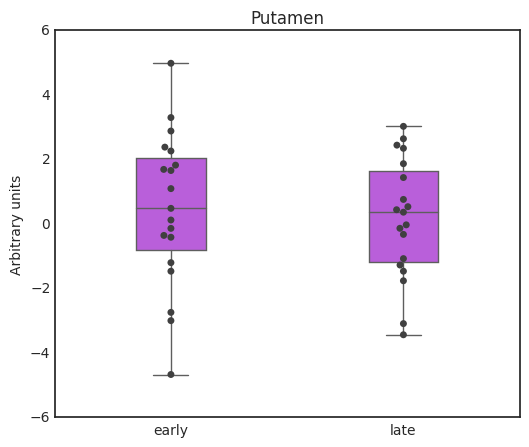

In [29]:
plot4 = {}
plot4['early'] = all_data_df[['put_all_early_learn','put_all_early_nonlearn']].mean(axis=1)
plot4['late'] = all_data_df[['put_all_late_learn','put_all_late_nonlearn']].mean(axis=1)
plot4_df = pd.DataFrame.from_dict(plot4)

for d in ['early', 'late']:
    print "Mean {0}: ".format(d), np.mean(plot4['{0}'.format(d)])
    print "STD {0}: ".format(d), np.std(plot4['{0}'.format(d)])
    print ""    
print "Early vs. Late t-test: ", stats.ttest_rel(plot4['early'], plot4['late'])[:]
                       
N = 2
conditions = ['early', 'late']
put_allsubjs = [plot4['early'], plot4['late']]
ind = np.arange(N)
fig, ax = plt.subplots(figsize = (6,5))
ax0 = sns.boxplot(data = put_allsubjs, color = "#c34aef", width = 0.3)
ax2 = sns.swarmplot(data = put_allsubjs, color='.25')
ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylabel("Arbitrary units")
#plt.savefig("/home/arenf001/halves-put2.jpg", dpi = 1080)
ax.set_title("Putamen")
plt.show()